In [106]:
from typing import Any
import numpy as np
from scipy.spatial import cKDTree, Voronoi, ConvexHull, voronoi_plot_2d
import scipy.stats
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd

def random_in_ellipse(lambdas:np.ndarray|list, size=None, mean_scale=False):
    lambdas = np.asarray(lambdas)
    d, = lambdas.shape
    shape = (1,) if size is None else tuple(np.ravel(size))
    x = np.random.normal(0, 1, size=(*shape, d))
    x = x / np.linalg.norm(x, axis=1)[:,None]
    x = x @ np.diag(lambdas)
    r = np.random.uniform(0, 1, size=shape)**0.5
    if mean_scale:
        r /= (d+1) / (d+2)
    x *= r[:,None]
    return x[0] if size is None else x

def categorical_to_one_hot(X_cat:np.ndarray, d:int|None=None):
    N = len(X_cat)
    d_ = d if d is not None else int(X_cat.max() + 1)
    Y = np.zeros((N, d_))
    Y[np.arange(N), X_cat.astype(int)] = 1
    return Y




[2.79331875 0.34064179] [0.56075948 0.15689898]
[2.79331875 0.34064179] [0.55940335 0.15651954]
[2.40485169 0.34489781] [1.26863231 0.4021144 ]
[2.40328828 0.35394963] [1.27278444 0.40704546]
[2.3704776 0.3714666] [1.2669483  0.40346874]
[2.4032561  0.35525264] [1.29469823 0.40307468]
[2.40522279 0.35584375] [1.29031477 0.40446267]


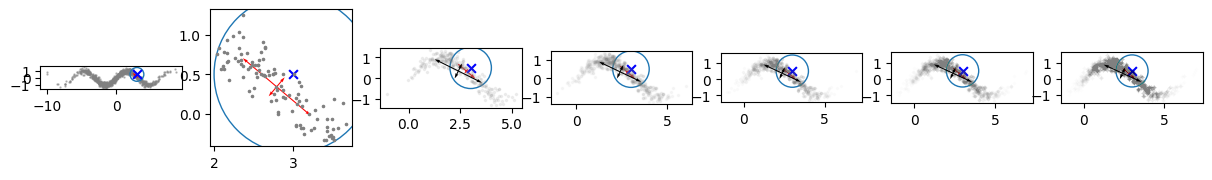

[2.72236045 0.37534425] [0.68901156 0.16476304]
[2.72236045 0.37534425] [0.68772007 0.16445421]
[2.42912822 0.32015579] [1.39756905 0.42414117]
[2.41193639 0.3335722 ] [1.36459136 0.41693222]
[2.36932417 0.33998172] [1.36458918 0.43752527]
[2.37457831 0.34654866] [1.35006342 0.42072691]
[2.39324607 0.33879684] [1.3580001  0.42330032]


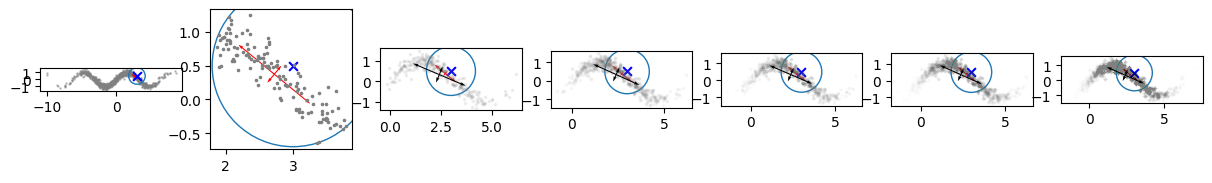

In [184]:
X = np.random.normal(0, 1, size=(1000, 2))
X[:,0] = X[:,0] * 3
X[:,1] = X[:,1] * 0.2 + np.sin(X[:,0])

d = X.shape[1]

xi = np.array([3, 0.5])
radius=1

for radius in [1, 1.2]:

    fig, axes = plt.subplots(1, 7, figsize=(15,5))
    axes = axes.flatten()
    axes[0].scatter(X[:,0], X[:,1], marker='.', s=2, alpha=0.5, color='gray')


    # Fuzzy balls test.
    # Choose an arbitrary point

    # Compute mean  and covariance of the points around it
    dists = np.linalg.norm(X - xi, axis=1)
    idx, = np.nonzero(dists < radius)
    mu = X[idx].mean(axis=0)
    cov = np.cov(X[idx].T)
    diag, V = np.linalg.eig(cov)
    lambdas = np.sqrt(diag)

    # for i_v in range(n):
    #     u = V[:, i_v] * lambdas[i_v]
    #     ax.quiver(*x, *u, scale=1, scale_units='xy', color='black', alpha=0.7, linewidths=0.5)
    for ax in axes:
        circle = plt.Circle(xi, radius, fill=False, color='tab:blue') # type: ignore
        ax.add_artist(circle)
        ax.quiver(*mu[None,:].repeat(2, axis=0).T, *(V*lambdas[None,:]), scale=1, scale_units='xy', color='red')
        ax.quiver(*mu[None,:].repeat(2, axis=0).T, *(-V*lambdas[None,:]), scale=1, scale_units='xy', color='red')
        ax.scatter(xi[None,0], xi[None,1], marker='x', s=40, c='blue')
        ax.set_aspect('equal')

    axes[1].scatter(X[idx,0], X[idx,1], marker='.', s=10, c='gray')

    def sigmoid(x:np.ndarray):
        return 1/(1+np.exp(-x))

    print(mu, lambdas)

    idx = np.concatenate([idx, idx], axis=-1)
    cov = np.cov(X[idx].T)
    D, V = np.linalg.eig(cov)
    lambdas = np.sqrt(D)
    print(mu, lambdas)


    # Now do it many times with fuzzy balls
    rad_uni = radius*(d+1)/(d+2)
    p = 1-scipy.stats.chi(d, rad_uni).cdf(dists)
    samples = []
    i_ax = 2
    for _ in range(5):
        for __ in range(2**_):
            idx, = np.nonzero(np.random.random(len(X)) < p)
            samples.append(idx)
        idx = np.concatenate(samples, axis=0)
        noise = np.random.normal(0,1, len(idx))

        mu = X[idx].mean(axis=0)
        cov = np.cov(X[idx].T)
        # draw the vectors
        D, V = np.linalg.eig(cov)
        lambdas = np.sqrt(D)

        ax = axes[i_ax]
        ax.scatter(X[idx,0]+noise*1e-2, X[idx,1]+noise*1e-2, marker='.', s=10, alpha=0.1/(1+_**2), color='gray')
        ax.quiver(*mu[None,:].repeat(2, axis=0).T, *(V*lambdas[None,:]), scale=1, scale_units='xy', color='black')
        ax.quiver(*mu[None,:].repeat(2, axis=0).T, *(-V*lambdas[None,:]), scale=1, scale_units='xy', color='black')
        print(mu, lambdas)
        i_ax += 1

    plt.show()

This experiment shows that the covariance matrix is stable with fuzzy neighborhoods.

I would like to replace hard neighborhoods with fuzzy neighborhoods because this provides a way of computing the covariance matrix when one of the attributes is categorical.
This is particularly useful when the radius is close but not enough to reach the categorical neighbors, because if we use a hard neighborhood, the points are simply not included (and the covariance matrix may have null eigenvalues, which should not be a problem in principle, but I think it makes numpy fail and it still makes correlations undefined). Instead, if we use a soft neighborhood, the points near the border will eventually be reached, but they will appear very few times.

Actually, it all boils down to exploring a neighborhood of sufficiently large radius, e.g. 3 times the original, and compute the covariance manually, weighting each sample with 1-chi(d,radius*(d+1)/(d+2)).cdf(distance), where d is the number of dimensions, so that the average distance from each point to the chosen center matches the one we would have obtained with a hard neighborhood. 


In the experiment above, I only tested that as we include more samples in the fuzzy neighborhood, the matrix converges.
I did not test above whether the covariance matrix is more stable with fuzzy neighborhoods instead of hard ones.
This is also true and is tested below.



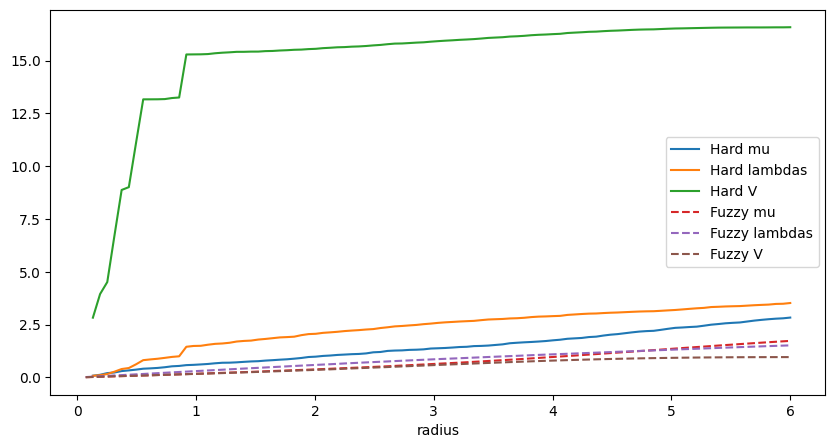

In [182]:

class NeighborhoodAround:
    def __init__(self,x:np.ndarray, X:np.ndarray):
        self.dists = np.linalg.norm(X-x, axis=1)
        self.x = x

    def fuzzy_ball(self, radius:float, alpha=0.95):
        d = len(self.x)
        radius = radius*(d+1)/(d+2) # correction for having the same radial mean as an uniform hard ball 
        ref_dist = scipy.stats.chi(d, radius)
        large_radius = ref_dist.ppf(alpha)
        idx, = np.nonzero(self.dists < large_radius)
        if len(idx)<=1:
            return self.x, np.nan*np.ones(d), np.nan*np.ones((d,d))
        probs = 1-ref_dist.cdf(self.dists)
        mu = np.average(X[idx], axis=0, weights=probs[idx])
        cov = np.cov(X[idx].T, aweights=probs[idx])
        diag, V = np.linalg.eig(cov)
        lambdas = np.sqrt(diag)
        return mu, lambdas, V

    def hard_ball(self, radius:float):
        idx, = np.nonzero(self.dists < radius)
        if len(idx)<=1:
            d = len(self.x)
            return self.x, np.nan*np.ones(d), np.nan*np.ones((d,d))
        mu = np.average(X[idx], axis=0)
        cov = np.cov(X[idx].T)
        diag, V = np.linalg.eig(cov)
        lambdas = np.sqrt(diag)
        return mu, lambdas, V


X = np.random.normal(0, 1, size=(1000, 2))
X[:,0] = X[:,0] * 3
X[:,1] = X[:,1] * 0.2 + np.sin(X[:,0])
d = X.shape[1]
xi = np.array([3, 0.5])

radii = np.linspace(1e-2, 6, 100)
Nx = NeighborhoodAround(xi, X)
data = []
for i_r, r in enumerate(radii):
    #if i_r % 5 == 0:
    data.append([r, True, *Nx.fuzzy_ball(r)])
    data.append([r, False, *Nx.hard_ball(r)])
data = pd.DataFrame(data, columns=['radius', 'fuzzy', 'mu', 'lambdas', 'V']).set_index(['radius', 'fuzzy'], drop=True)

movements = data.dropna()
movements = movements.groupby(level='fuzzy').diff()
movements = movements.map(np.linalg.norm)
movements = movements.dropna()
# Cumulative sum of the movements
movements = movements.groupby(level='fuzzy').cumsum()

fig, ax = plt.subplots(1, 1, figsize=(10,5))
for key, sub in movements.reset_index('fuzzy').groupby(by='fuzzy'):
    s = 'Fuzzy' if key else 'Hard'
    columns = {c:f"{s} {c}" for c in sub.columns}
    sub.rename(columns=columns).plot(ls='--' if key else '-', ax=ax)
plt.show()

Now, let's use a decent heuristic for scaling the one-hot embeddings so that their scale is in some sense comparable to the scale of continuous attributes.
We scale all continuous attributes so that the mean is zero and the std. is 1.

I propose to use the expected number of samples around the population mean at radius 1 to tune the scales.
For instance, in 1D, the hard ball of radius 1 contains 68.3% of the population.
In 2D, or kD, this number is `(scipy.stats.)chi(k).cdf(1)`.

In the categorical world, the observation universe is the set of one-hot encodings, e.g. `[1,0,0],[0,1,0],[0,0,1]` for `d=3`, the embedding center is `1/d*np.ones(d)`, and the distance from the center to any encoding is (after some simple algebra) `np.sqrt((d-1)/d)`.
We would like a fuzzy ball of radius 1 to contain a proportion of samples equal to `chi(k).cdf(1)`.
Well, since the fuzzy balls are defined based on the `chi` distribution itself, this is the same as **simply scaling the categorical embeddings** by `np.sqrt(d/(d-1))`, so that the distance from the center to any encoding is exactly 1, and the probability of including it is exactly `chi(k).cdf(1)`.

Actually, this analysis reveals that there is a better way of scaling the radius of fuzzy neighborhoods with respect to that of a hard neighborhood. Compare the area (i.e. volume) of the hard neighborhood with the total measure of the fuzzy ball assuming an underlying uniform measure.
This integral looks daunting, but I may try numerically to find a pattern quickly.


In [410]:
# The whole derivation is commented. The result is what really matters.
# # This scales with the radius:
# hypersurface = lambda d: 2*np.pi**(d/2)/scipy.special.gamma(d/2)
# for d,radius in [(2,1), (2,10), (3, 1), (3,10)]:
#     value, err = scipy.integrate.quad(lambda r: hypersurface(d)*r**(d-1) * (1-scipy.stats.chi(d).cdf(r/radius)), 0, np.inf)
#     print(d,radius,value)

# # Simpler version:
# for d, radius in [(2,1), (2,10), (3, 1), (3,10)]:
#     value, err = scipy.integrate.quad(lambda r: r**(d-1) * (1-scipy.stats.chi(d).cdf(r)), 0, np.inf)
#     print(value)
#     value *= hypersurface(d) * radius**d
#     print(d,radius,value, hypersurface(d))

# for d in np.arange(1, 10):
#     value, err = scipy.integrate.quad(lambda r: r**(d-1) * (1-scipy.stats.chi(d).cdf(r)), 0, np.inf)
#     print(d, value, int(np.round(value)))
    
# print(4, scipy.special.factorial(5) / 3 * 2)
# print(6, scipy.special.factorial(5) / 3 * 2)
# print(6, scipy.special.factorial(6) / 9)
# print(8, scipy.special.factorial(7) / 3)
# print(8, scipy.special.factorial(8) / 24)

# def factor_decomposition(n):
#     out = []
#     i = 2
#     while n>1:
#         while n%i==0:
#             out.append(i)
#             n//=i
#         i+=1
#     return out

# factor_decomposition(4151347200)

# print(12, 1774080/11/9/7/5/3 * 12  / 2**11)
# print(14, 79073280/13/11/9/7/5/3 * 14  / 2**13)
# print(16, 4151347200/15/13/11/9/7/5/3 * 16  / 2**15)

# # For even numbers, it's 
# double_fact = lambda d: 2**((d+1)/2) * scipy.special.gamma(1+d/2)/np.sqrt(np.pi)

# for d in np.arange(1, 20, 2):
#     value, err = scipy.integrate.quad(lambda r: r**(d-1) * (1-scipy.stats.chi(d).cdf(r)), 0, np.inf)
#     if d%2 ==1:
#         value = value / np.sqrt(2/np.pi)
#         value *= d
#     if np.isclose(value, np.round(value)):
#         value = int(np.round(value))
#     print(d, 'value=', value)

#     if d%2==0:
#         print(d, double_fact(d-1) * 2**(d-1) /d)
#     else:
#         print(d, scipy.special.gamma(1 + (d-1)/2) * 8**((d-1)/2))
#         pass

#     # print(2 * (2*np.pi)**((d-1)/2)/)
#     # print(np.sqrt(2/np.pi) * 2**((d-1)/2) * scipy.special.gamma(1+(d-1)/2))
# print(1, 1)
# print(3, 1*3)
# print(5, 1*3*5)
# print(7, 1*3*5*7)
# print(9, 1*3*5*7*9)
# for d in [1,3,5,7,9]:
#     print(2**((d+1)/2) * scipy.special.gamma(1+d/2)/np.sqrt(np.pi))
# for d in range(10):
#     value, err = scipy.integrate.quad(lambda r: r**(d-1) * (1-scipy.stats.chi(d).cdf(r)), 0, np.inf)
#     print(value)
#     double_fact = 2**((d+1)/2) * scipy.special.gamma(1+d/2)/np.sqrt(np.pi)
#     print(double_fact)
#     #print(scipy.special.gamma((d+1)/2) / scipy.special.gamma(d/2+1))
# #11:2**18 * 15
# # A051189: n! * 8**n
# factor_decomposition(10569646080)

# double_fact = lambda d: 2**((d+1)/2) * scipy.special.gamma(1+d/2)/np.sqrt(np.pi)
# formula_even = lambda d: double_fact(d-1) * 2**(d-1) / d
# formula_odd = lambda d: np.sqrt(2/np.pi)/d* scipy.special.gamma(1 + (d-1)/2) * 8**((d-1)/2)
# formula = lambda d: formula_even(d) if d%2==0 else formula_odd(d)

# for d in np.arange(1, 20, 2):
#     integral, err = scipy.integrate.quad(lambda r: r**(d-1) * (1-scipy.stats.chi(d).cdf(r)), 0, np.inf)
#     print(d, integral)
#     print(d, formula(d))

# # We are interested in integral/volume

# hypervolume = lambda d: np.pi**(d/2) / scipy.special.gamma(1+d/2)
# hypersurface = lambda d: 2*np.pi**(d/2)/scipy.special.gamma(d/2)

# for d,radius in [(2,1), (2,10), (3, 1), (3,10)]:
#     integral, err = scipy.integrate.quad(lambda r: hypersurface(d)*r**(d-1) * (1-scipy.stats.chi(d).cdf(r/radius)), 0, np.inf)
#     volume = hypervolume(d) * radius**d
#     print(integral / volume)


# # for d in range(10):
# #     print(d, hypersurface(d) / hypervolume(d))


hypervolume = lambda d: np.pi**(d/2) / scipy.special.gamma(1 + d/2)
hypersurface = lambda d: d * hypervolume(d)

def fuzzy_unitary_radius(d):
    '''
    Radius R of the fuzzy neighborhood in d dimensions
    that has the same total weight (number of elements) as the
    hard neighborhood of raidus 1 in d dimensions.
    '''
    integral = scipy.special.gamma(1 + (d-1)/2) * 2**(3*d/2 - 1) / np.sqrt(np.pi)
    R = integral ** (-1/d)
    return R

data = []
for d in range(1, 11):
    R = fuzzy_unitary_radius(d)
    w, _  = scipy.integrate.quad(lambda r: hypersurface(d)*r**(d-1) * (1-scipy.stats.chi(d).cdf(r/R)), 0, np.inf)
    data.append((d,hypervolume(d), w, R))
display(pd.DataFrame(data, columns=['d','Volume', 'Weight', 'Radius']).set_index('d'))


,Volume,Weight,Radius
d,,,
1,2.000000,2.000000,1.253314
2,3.141593,3.141593,0.707107
3,4.188790,4.188790,0.539084
4,4.934802,4.934802,0.451801
5,5.263789,5.263789,0.396433
6,5.167713,5.167713,0.357377
7,4.724766,4.724766,0.327948
8,4.058712,4.058712,0.304754
9,3.298509,3.298509,0.285868


In [ ]:

hypervolume = lambda d: np.pi**(d/2) / scipy.special.gamma(1 + d/2)
hypersurface = lambda d: d * hypervolume(d)

def fuzzy_unitary_radius(d):
    '''
    Radius R of the fuzzy neighborhood in d dimensions
    that has the same total weight (number of elements) as the
    hard neighborhood of raidus 1 in d dimensions.
    '''
    integral = scipy.special.gamma(1 + (d-1)/2) * 2**(3*d/2 - 1) / np.sqrt(np.pi)
    R = integral ** (-1/d)
    return R

class FuzzyNeighborhood:

    def __init__(self,x:np.ndarray, X:np.ndarray):
        self.dists = np.linalg.norm(X-x, axis=1)
        self.x = x

    def fuzzy_ball(self, radius:float, alpha=0.95):
        d = len(self.x)
        radius *= fuzzy_unitary_radius(d)
        ref_dist = scipy.stats.chi(d, radius)
        large_radius = ref_dist.ppf(alpha)
        idx, = np.nonzero(self.dists < large_radius)
        if len(idx)<=1:
            return self.x, np.nan*np.ones(d), np.nan*np.ones((d,d))
        probs = 1-ref_dist.cdf(self.dists)
        mu = np.average(X[idx], axis=0, weights=probs[idx])
        cov = np.cov(X[idx].T, aweights=probs[idx])
        diag, V = np.linalg.eig(cov)
        lambdas = np.sqrt(diag)
        return mu, lambdas, V

    def hard_ball(self, radius:float):
        idx, = np.nonzero(self.dists < radius)
        if len(idx)<=1:
            d = len(self.x)
            return self.x, np.nan*np.ones(d), np.nan*np.ones((d,d))
        mu = np.average(X[idx], axis=0)
        cov = np.cov(X[idx].T)
        diag, V = np.linalg.eig(cov)
        lambdas = np.sqrt(diag)
        return mu, lambdas, V
